## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import pickle

import warnings
warnings.filterwarnings("ignore")

## Reading TMDB Movies data:

In [2]:
path1="/content/drive/MyDrive/Placement projects/1_recom_system/TMDB_data/tmdb_5000_credits.csv"    #cast,crew data of each movie
path2="/content/drive/MyDrive/Placement projects/1_recom_system/TMDB_data/tmdb_5000_movies.csv"     #Other movie info
path3="/content/drive/MyDrive/Placement projects/1_recom_system/TMDB_data/ratings_small.csv"        #Ratings of each movie


#Cast and Crew data:
df_credits=pd.read_csv(path1)
df_credits.rename(columns={'title':'movie'},inplace=True)

#Movie Other info:
df_movies=pd.read_csv(path2)
df_movies.rename(columns={'id':'movie_id','title':'movie'},inplace=True)

#Merged Datae:
df=df_credits.merge(df_movies, how='inner', on=['movie_id','movie'])

#Ratings from users for movies:
df_ratings=pd.read_csv(path3)

In [3]:
print('Total data=',len(df))
print('Columns=',df.columns)
print('Total columns=',len(df.columns))
df.head(2)

Total data= 4803
Columns= Index(['movie_id', 'movie', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count'],
      dtype='object')
Total columns= 22


,movie_id,movie,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500


In [4]:
print('Total Unique Users:',df_ratings['userId'].nunique())
print('Total Unique Movies:',df_ratings['movieId'].nunique())
df_ratings

Total Unique Users: 671
Total Unique Movies: 9066


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


## 1. Demographic Filtering:

* 1. Calculate IMDB using formula
* 2. Then recommend top rated imdb movie to all target users, it will give same recommendations to all users

The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating 
$ (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C $ where:

where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

In [5]:
C=sum(df['vote_average'])/len(df)

percentile_limit=0.7
m=df['vote_count'].quantile(percentile_limit)    #calculate threshold limit for vote_count

print('Net Avg rating of all movies together =',C)
print('90 percentile mark for Vote count=',m)

def calculate_weighted_avg(df,C,m):
      v=df['vote_count']
      R=df['vote_average']
      WR = (v /(v+m))*R + (m /(v+m))*C
      return WR

Net Avg rating of all movies together = 6.092171559442011
90 percentile mark for Vote count= 581.0


In [6]:
df['IMDB']=df.apply(lambda x:calculate_weighted_avg(x,C,m),axis=1)   #apply column wise
df.sort_values(by = 'IMDB',ascending=False,inplace=True)   #sort in decreasing IMDB ratings

df=df[df['vote_count']>m]     #selecting only those movie whose (percentile > threshold percentile_limit )===> vote_count> m(threshold limit for vote count)

In [7]:
df.head(2)

,movie_id,movie,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,IMDB
1881,278,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,8.5,8205,8.340775
3337,238,The Godfather,"[{""cast_id"": 5, ""character"": ""Don Vito Corleon...","[{""credit_id"": ""52fe422bc3a36847f80093c9"", ""de...",6000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",http://www.thegodfather.com/,"[{""id"": 131, ""name"": ""italy""}, {""id"": 699, ""na...",en,The Godfather,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-14,245066411,175.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,An offer you can't refuse.,8.4,5893,8.192887


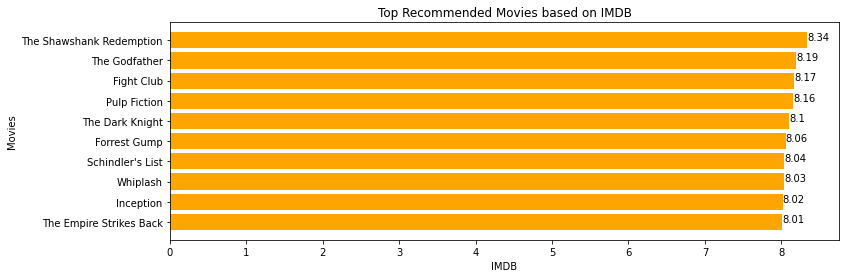

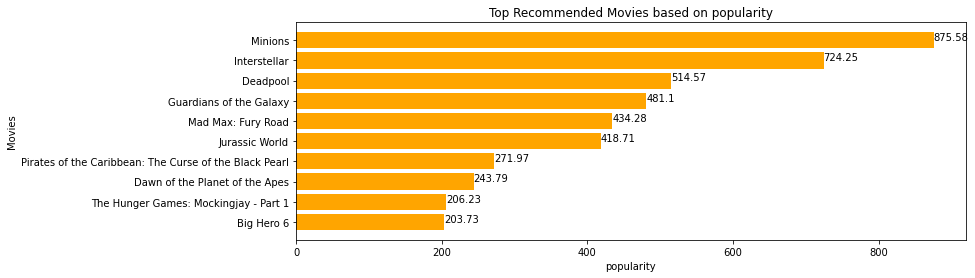

In [8]:
def plot_best(df,top=10,based_on='IMDB'):
    plt.figure(figsize=(12,4))
    df2=df.sort_values(based_on, ascending=False)

    x=df2['movie'].head(top)
    y=df2[based_on].head(top)
    plt.barh(x,y, align='center', color='orange')
    for index, value in enumerate(y):
        plt.text(value, index,str(round(value,2)))
    plt.gca().invert_yaxis()
    plt.xlabel(based_on)
    plt.ylabel('Movies')
    plt.title(f"Top Recommended Movies based on {based_on}")

plot_best(df,10,'IMDB')    
plot_best(df,10,'popularity')

Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user.
So we can try a more refined system-  Content Basesd Filtering. 

In [9]:
def recommend(df,top=10,based_on='IMDB'):
    df2=df.sort_values(based_on, ascending=False)   #sorting criteria-->based_on variable
    return list(df2['movie'].head(top))    #return list of Top movie recommendations
recommend(df,based_on='IMDB')

['The Shawshank Redemption',
 'The Godfather',
 'Fight Club',
 'Pulp Fiction',
 'The Dark Knight',
 'Forrest Gump',
 "Schindler's List",
 'Whiplash',
 'Inception',
 'The Empire Strikes Back']

## 2. Content Based Filtering:

* Using Meta-Data for each movie to recommend a New movie to user:
* Extract Meta-data to form vectors and calculate cosine similarity

* 1.This meta data can be converted to vectors using proper embedding model--tfidf,or bert or word2vec
* 2.Find cosine similarity and recoomennd top similar movies 

In [10]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

# 1. Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


# 2. Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []    

# 3. Define new director, cast, genres and keywords features that are in a suitable form.
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(get_list)

# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

def create_combined_string(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])


df['text'] = df.apply(create_combined_string, axis=1)  

In [11]:
print('Tot columns=',len(df.columns))
df.columns

Tot columns= 25


Index(['movie_id', 'movie', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'IMDB', 'director', 'text'],
      dtype='object')

### Calculating cosine similarity

In [12]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

df=df.reset_index()   #reset indexes
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['text'])

In [13]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix= cosine_similarity(count_matrix, count_matrix)

In [14]:
def movie_2_id_map(df):
    d={}
    for i in range(len(df)):
        movie=df.loc[i,'movie']
        if movie not in d:
            d[movie]=i
    return d        
mapping=movie_2_id_map(df)

In [15]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(df,mapping,title,cosine_sim):                #Find similar most similar on basis of cosine similarity matrix
    idx = mapping[title]   #form movie title get index for cosine matrix
    
    sim_scores = list(enumerate(cosine_sim[idx]))   # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)   # Sort the movies based on the similarity scores
    sim_scores = sim_scores[1:11]   # Get the scores of the 10 most similar movies

    movie_indices = [i[0] for i in sim_scores]   # Get the movie indices
    return list(df['movie'].iloc[movie_indices])    # Return the top 10 most similar movies

movie='Superman'

print('Recommendations:')
get_recommendations(df,mapping,movie,cosine_matrix)

Recommendations:


['Superman II',
 'Man of Steel',
 'Superman Returns',
 'Batman v Superman: Dawn of Justice',
 'The Mummy: Tomb of the Dragon Emperor',
 'Raiders of the Lost Ark',
 'Indiana Jones and the Last Crusade',
 'Batman',
 "The Sorcerer's Apprentice",
 'Indiana Jones and the Kingdom of the Crystal Skull']

### Get data for Streamlit Web App

In [16]:
#pickle.dump(df.to_dict(),open('movies_dict.pkl','wb'))

In [17]:
#pickle.dump(cosine_matrix,open('cosine_similarity_matrix.pkl','wb'))

In [18]:
#d=pickle.load(open('movies_dict.pkl','rb'))   load
#print(d)

## 3. Collborative Filltereing  Memory Based:
* 1.Find user-item --->pivot table
* 2.Impute missing values strategically--based on mean or 0, or do mean filtering

In [50]:
df_ratings[df_ratings['movieId']==1]

,userId,movieId,rating,timestamp
495,7,1,3.0,851866703
699,9,1,4.0,938629179
889,13,1,5.0,1331380058
962,15,1,2.0,997938310
3105,19,1,3.0,855190091
...,...,...,...,...
98531,660,1,2.5,1436680062
98714,663,1,4.0,1438397999
98740,664,1,3.5,1362421730
99858,670,1,4.0,938782344


### user-Item matrix :

In [20]:
n_users=df_ratings['userId'].nunique()
n_items=df_ratings['movieId'].nunique()

print('total user=',n_users)
print('total movies=',n_items)

matrix = df_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')

total user= 671
total movies= 9066


In [21]:
matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impute Nan values with Mean

In [22]:
matrix=matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,...,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000,2.550000
2,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,4.000000,...,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842,3.486842
3,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,...,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627,3.568627
4,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.000000,...,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039,4.348039
5,3.910000,3.910000,4.000000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,...,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000,3.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3.647059,3.647059,3.647059,3.647059,3.647059,4.000000,3.647059,3.647059,3.647059,3.647059,...,3.647059,3.647059,3.647059,3.647059,3.647059,3.647059,3.647059,3.647059,3.647059,3.647059
668,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,...,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000
669,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,...,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351,3.351351


### 3.1 user-user CF

* 1. Find user-user corr() matrix
* 2. For a given target user Id--->find top similar users based on corr()
* 3. For a given movie whcih target user hasnot given rating , find its ratings based on weighted avg ratings of other similar users that have rated that move,
* 4. Do 3rd step for all non rated movies(for target user) and based on highest rating pick top movies

In [23]:
user_corr=matrix.corr()
user_corr

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000e+00,-8.800508e-17,-4.038337e-16,0.003620,-0.002274,9.056684e-17,-0.070321,8.038379e-16,0.042632,4.847847e-17,...,1.761252e-16,2.295676e-15,0.018643,0.001031,-2.641629e-17,-3.151749e-16,9.222364e-16,4.409492e-02,6.768814e-16,-0.013096
2,-8.800508e-17,1.000000e+00,-1.851833e-03,-0.004854,0.012639,1.589358e-16,0.042691,2.106603e-02,0.011109,-7.989496e-03,...,-1.824770e-02,-2.154635e-02,0.018902,-0.058952,2.851502e-02,-1.068281e-01,-7.998716e-03,-4.162816e-02,-9.023348e-02,0.056258
3,-4.038337e-16,-1.851833e-03,1.000000e+00,0.018594,-0.025903,-6.320034e-02,0.054900,2.648842e-02,-0.036187,3.802061e-02,...,4.429739e-02,1.958052e-02,0.070702,0.030669,1.437054e-01,9.671306e-02,2.745062e-02,8.929665e-02,-9.815091e-03,0.062276
4,3.619871e-03,-4.854054e-03,1.859363e-02,1.000000,0.010801,1.922361e-02,0.057519,5.542968e-02,-0.010442,5.126352e-03,...,1.197787e-02,6.569291e-03,0.027687,0.092092,2.133368e-02,4.083265e-02,1.842823e-02,2.864172e-02,1.984817e-02,0.032749
5,-2.274173e-03,1.263945e-02,-2.590271e-02,0.010801,1.000000,-5.843286e-03,-0.015075,-3.888612e-02,0.013708,3.050043e-02,...,4.613436e-02,1.903123e-03,0.001620,0.036819,-3.826929e-02,-1.953717e-02,-7.172134e-02,3.759695e-03,-2.945517e-02,-0.036814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,-3.151749e-16,-1.068281e-01,9.671306e-02,0.040833,-0.019537,-1.219931e-16,0.048268,2.380021e-02,0.042599,3.677591e-02,...,4.885788e-04,8.705799e-04,0.037650,0.019787,9.404957e-02,1.000000e+00,8.706946e-02,-3.260577e-03,-5.466801e-03,0.035538
668,9.222364e-16,-7.998716e-03,2.745062e-02,0.018428,-0.071721,-6.875973e-03,-0.015626,1.182188e-02,0.054536,2.669090e-02,...,-2.540580e-03,2.640728e-02,0.043421,0.026688,7.196982e-02,8.706946e-02,1.000000e+00,-4.369568e-16,8.699100e-02,0.028488
669,4.409492e-02,-4.162816e-02,8.929665e-02,0.028642,0.003760,-5.780024e-03,0.037506,-9.157719e-03,0.004907,-9.258005e-03,...,3.812793e-03,6.498484e-03,0.045351,0.079319,-1.033131e-02,-3.260577e-03,-4.369568e-16,1.000000e+00,2.095823e-02,0.045097


In [142]:
def get_mappings(df):
    map_id2movie={}
    for i in range(len(df)):
        id=df['movie_id'].iloc[i]
        Movie=df['movie'].iloc[i]
        map_id2movie[id]=Movie
    map_movie2id={val:key for key,val in map_id2movie.items()} 
    movie_list=[key for key in map_movie2id.keys()] 
    return map_id2movie,map_movie2id,movie_list

map_id2movie,map_movie2id,movie_list=get_mappings(df)

In [ ]:
def similar_users(Id,user_corr,top=100):                            #Find Top similar users based on correlation
    select=user_corr[Id].sort_values(ascending=False)[1:top].index
    return list(select)

id=1
top_same_users=similar_users(id,user_corr)
top_same_users

In [143]:
def calculate_rating(id,movieid,top_same_users,user_corr,df):      #based on top similar user, find the rating the target user will give using weighted avg of all other ratings similar users give
    res=0
    denominator=0   #adds up all the correlation of other users with target user=id
    for user in top_same_users:
        corr_with_target_user=user_corr[id][user]
        if df[(df['userId']==user )& (df['movieId']==movieid)]['rating'].sum():  #if rating is given
            rating_by_user=df[(df['userId']==user )& (df['movieId']==movieid)]['rating'].item()   
            denominator+=corr_with_target_user   
            res+=corr_with_target_user*rating_by_user     
    final_rating=res/(denominator+0.0000000000000001)
    return final_rating     

target_id=1
movie_id=31
rating=calculate_rating(target_id,movie_id,top_same_users,user_corr,df_ratings)
print('Predicted rating by target user based on similar users=',rating)

Predicted rating by target user based on similar users= 2.6610594648852284


In [145]:
def recommend(Id,df,top=10):
    ratings=[]
    for movieid,movie in map_id2movie.items():
        if not df[(df['userId']==Id )& (df['movieId']==movieid)]['rating'].sum(): 
            top_same_users=similar_users(Id,user_corr,top=10)     
            rating=calculate_rating(Id,movieid,top_same_users,user_corr,df)
            #print(rating)
            ratings.append([rating,movie])        
    ratings.sort(key=lambda x:x[0],reverse=True)      
    return [x[1] for x in ratings[1:top]]  

i=4
name=movie_list[i]
id=map_movie2id[name]
print('Input movie:',name, end='\n')
print(end='\n')

print('Recommended Movies')
res=recommend(id,df_ratings,top=10) 
for i in res:
    print(i)  

Input movie: The Dark Knight

Recommended Movies
Amélie
Rosemary's Baby
Beetlejuice
Batman
Stranger Than Fiction
Cube
Galaxy Quest
Madagascar
The Bourne Supremacy


In [148]:
df_ratings[df_ratings['userId']==1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


### 3.2 Item-Item CF

* 1. Find item-item corr() matrix
* 2. For a given item find top similar item to target item and recommend that item to target user

In [24]:
item_corr=matrix.corr()

In [25]:
item_corr

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.551786,0.534809,0.587170,0.570575,0.512782,0.569276,0.645728,0.618634,0.533534,...,0.661281,0.660123,0.660259,0.638785,0.646550,0.663447,0.668028,0.658754,0.662381,0.657611
2,0.551786,1.000000,0.697997,0.762653,0.724846,0.647131,0.746155,0.832135,0.806321,0.763507,...,0.847698,0.844420,0.851333,0.838608,0.843439,0.850585,0.841105,0.845172,0.848604,0.842722
3,0.534809,0.697997,1.000000,0.772844,0.775196,0.641683,0.714122,0.835689,0.803258,0.697114,...,0.833704,0.823281,0.835529,0.824648,0.829447,0.835424,0.832759,0.831374,0.834622,0.829010
4,0.587170,0.762653,0.772844,1.000000,0.808008,0.729752,0.808424,0.878887,0.877075,0.766000,...,0.912272,0.901344,0.914204,0.903840,0.908681,0.914091,0.910978,0.909518,0.913209,0.906809
5,0.570575,0.724846,0.775196,0.808008,1.000000,0.719230,0.755893,0.851946,0.829240,0.723504,...,0.872249,0.839072,0.874106,0.863006,0.867944,0.874007,0.871051,0.869654,0.873151,0.867075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.663447,0.850585,0.835424,0.914091,0.874007,0.795086,0.868225,0.971255,0.954036,0.828852,...,0.996773,0.985006,0.998804,0.987708,0.992922,1.000000,0.995036,0.993403,0.997768,0.990401
162376,0.668028,0.841105,0.832759,0.910978,0.871051,0.799091,0.865384,0.967863,0.950748,0.823472,...,0.993283,0.981627,0.992478,0.984295,0.989476,0.995036,1.000000,0.989904,0.994265,0.986894
162542,0.658754,0.845172,0.831374,0.909518,0.869654,0.790679,0.863924,0.966275,0.949209,0.824614,...,0.991658,0.979995,0.993672,0.982669,0.987846,0.993403,0.989904,1.000000,0.986694,0.985285


In [82]:
print(movie_list[:20])

['The Shawshank Redemption', 'The Godfather', 'Fight Club', 'Pulp Fiction', 'The Dark Knight', 'Forrest Gump', "Schindler's List", 'Whiplash', 'Inception', 'The Empire Strikes Back', 'Spirited Away', 'Interstellar', 'The Godfather: Part II', 'The Lord of the Rings: The Return of the King', 'Star Wars', 'The Green Mile', 'Se7en', 'The Lord of the Rings: The Fellowship of the Ring', 'GoodFellas', 'The Silence of the Lambs']


In [99]:
def get_item_recommend(Id,item_corr,top=100):
    select=item_corr[Id].sort_values(ascending=False)[1:top].index
    return list(select)


i=4
name=movie_list[i]
id=map_movie2id[name]
print('Input movie:',name, end='\n')
print(end='\n')

print('Recommended Movies')
res=get_item_recommend(id,item_corr)

print(res)
for i in res:
    if i in map_id2movie:
        print(map_id2movie[i])  

Input movie: The Dark Knight

Recommended Movies
[2260, 1043, 1798, 3094, 5644, 6357, 536, 1989, 3518, 2850, 131, 1053, 1549, 1696, 775, 3838, 1891, 2519, 2479, 2515, 2868, 3714, 1442, 220, 8535, 304, 2878, 2370, 7787, 2844, 3834, 1971, 6797, 997, 1508, 8617, 6735, 1369, 2464, 3921, 2967, 1331, 6829, 8929, 5836, 32139, 6630, 6423, 6636, 3920, 4667, 91610, 4606, 47894, 98458, 26689, 4840, 129364, 4555, 26581, 26487, 8003, 143657, 101088, 8851, 38994, 746, 89321, 5033, 78111, 108076, 44073, 7585, 25965, 4392, 8392, 86982, 112450, 44911, 4332, 2239, 3540, 697, 3613, 5359, 4276, 4503, 4704, 6480, 7142, 1413, 3061, 3937, 4080, 3962, 8763, 110858, 26775, 96565]
The Empire Strikes Back
Rambo: First Blood Part II


## 4. Model Based :

In [150]:
df_ratings   #data:

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


#### Train test split

In [164]:
x=df_ratings[['userId','movieId']].to_numpy()
y=df_ratings['rating'].to_numpy()

xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size=0.2, random_state=42)
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(80003, 2)
(80003,)
(20001, 2)
(20001,)


### Linear Reg and XGBOOST models

In [165]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
LR=LinearRegression()
LR.fit(xtrain,ytrain)

LinearRegression()

In [170]:
from sklearn.metrics import mean_squared_error
ypred_train=LR.predict(xtrain)
ypred_test=LR.predict(xtest)

train_error=mean_squared_error(ytrain, ypred_train, squared=False)
test_error=mean_squared_error(ytest, ypred_test, squared=False)

print('train RMSE=',train_error)
print('test RMSE=',test_error)

train RMSE= 1.057003522908971
test RMSE= 1.0597884495372774


In [177]:
import xgboost as xg
xgb= xg.XGBRegressor(n_estimators = 10, seed = 123)
xgb.fit(xtrain,ytrain)

ypred_train2=xgb.predict(xtrain)
ypred_test2=xgb.predict(xtest)

train_error_xgb=mean_squared_error(ytrain, ypred_train2, squared=False)
test_error_xgb=mean_squared_error(ytest, ypred_test2, squared=False)

print('train RMSE=',train_error_xgb)
print('test RMSE=',test_error_xgb)

[08:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train RMSE= 1.4848362442633303
test RMSE= 1.4957325065385905


### DL model:

In [8]:
from keras.layers import Embedding, Input, dot, concatenate,Flatten
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

In [4]:
# Model Architecture
size=193609+1


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim =size , output_dim=50, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = size, output_dim=50, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

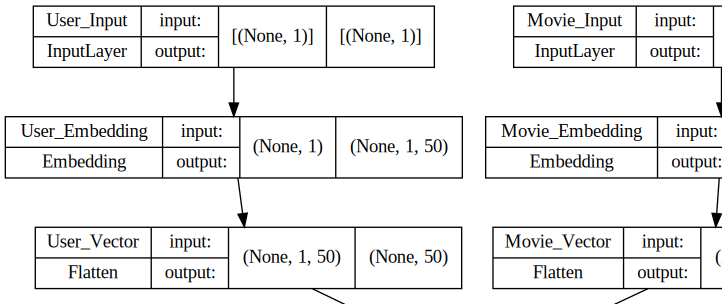

In [182]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [5]:
optimizer = Adam(lr = 0.0005)
model.compile(loss='mean_squared_error', optimizer = optimizer)

In [9]:
X = df_ratings.iloc[:,:2]
Y = df_ratings.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

In [10]:
batch_size = 128
epochs = 5


history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
                    batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

Epoch 1/5
626/626 - 12s - loss: 13.6398 - val_loss: 13.4337 - 12s/epoch - 19ms/step
Epoch 2/5
626/626 - 8s - loss: 11.1228 - val_loss: 7.6950 - 8s/epoch - 13ms/step
Epoch 3/5
626/626 - 8s - loss: 4.9092 - val_loss: 3.5478 - 8s/epoch - 12ms/step
Epoch 4/5
626/626 - 8s - loss: 2.5663 - val_loss: 2.4280 - 8s/epoch - 13ms/step
Epoch 5/5
626/626 - 8s - loss: 1.7587 - val_loss: 1.9328 - 8s/epoch - 12ms/step


In [11]:
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
                    batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

Epoch 1/5
626/626 - 8s - loss: 1.3545 - val_loss: 1.6683 - 8s/epoch - 12ms/step
Epoch 2/5
626/626 - 8s - loss: 1.1179 - val_loss: 1.5117 - 8s/epoch - 12ms/step
Epoch 3/5
626/626 - 8s - loss: 0.9642 - val_loss: 1.4123 - 8s/epoch - 12ms/step
Epoch 4/5
626/626 - 8s - loss: 0.8563 - val_loss: 1.3496 - 8s/epoch - 12ms/step
Epoch 5/5
626/626 - 8s - loss: 0.7777 - val_loss: 1.3057 - 8s/epoch - 12ms/step
